# Exploring Cell Coverage of Routes
* To do later: move data sources to a catalog
* An agency here is defined: as a service and an operator...

In [1]:
# Read in zip files
import fsspec
import geopandas as gpd
import intake
import numpy as np
import pandas as pd

# My utilities
import utilities
from calitp import *

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## Trip Routes 
* Bring in trip routes.

In [4]:
# Just grab some columns w/o geo, in case I want to preview the df
cols_without_geometry = [
    "agency",
    "route_name",
    "itp_id",
    "route_id",
    "route_type",
]

In [5]:
routes_df = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes.parquet"
)

In [6]:
# Find unique routes for bus only
routes_df = utilities.unique_routes(routes_df)

In [170]:
routes_df.dtypes

itp_id             int64
route_id          object
geometry        geometry
route_type        object
route_name        object
agency            object
route_length     float64
dtype: object

In [241]:
# Fill in NA for route names and agency names
routes_df["route_name"] = routes_df["route_name"].replace({"": "None"})

In [242]:
f"""{routes_df.route_id.nunique()} unique route ids, {routes_df.route_name.nunique()} different route names, and {routes_df.route_length.nunique()} different shape ids. The dataframe has {len(routes_df)} rows."""

'1730 unique route ids, 1930 different route names, and 2318 different shape ids. The dataframe has 2829 rows.'

In [243]:
# Route ID is only unique to each agency.
# routes_df[["agency",  "route_name",  "route_id",]].sort_values(['agency',"route_name", 'route_id', ]).drop_duplicates().reset_index(drop = True)

In [244]:
# Create a df for agency-itp id, drop duplicates to get only one record per agency
agency_itp = routes_df[["agency", "itp_id"]].drop_duplicates()

In [245]:
agency_itp.shape

(169, 2)

## FCC Maps
* T-Mobile file is split for each state and I can't find documentation on fcc's website on which zip file corresponds to CA. 
* Emailed FCC for clarification.
* FCC said "there is no way to tell which file corresponds with which state."

In [246]:
# verizon_df = gpd.read_parquet(f"{GCS_FILE_PATH}verizon_ca_only.parquet")

In [247]:
att_df = gpd.read_parquet(f"{GCS_FILE_PATH}att_ca_only.parquet")

<AxesSubplot:>

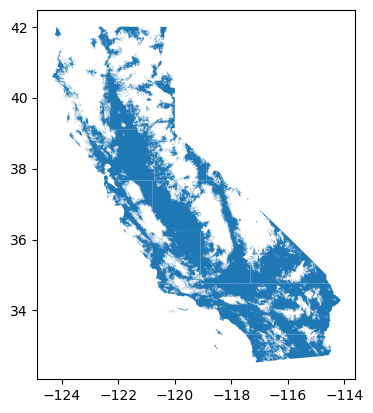

In [248]:
att_df.plot()

In [249]:
# att_df.plot(), verizon_df.plot(),

## Overlay AT&T with Trip Routes

In [250]:
# overlay_verizon = utilities.comparison(routes_df, verizon_df)

In [251]:
overlay_att = utilities.comparison(routes_df, att_df)

In [252]:
# f"Verizon: The length of the overlay dataframe is {len(overlay_verizon)}"

In [253]:
# f"AT&T: The length of the overlay dataframe is {len(overlay_att)}"

In [254]:
# overlay_att.plot("route_length", legend=True), overlay_verizon.plot("route_length")

### Test with bus routes x California Counties first
* Using counties just because it seems like a lot more routes cross counties instead of districts.
* Tested with these agencies that are in a remote area:
* "Tahoe Truckee Area Regional Transportation"
    * https://tahoetruckeetransit.com/interactive-map/
* 'Trinity Transit' 
* 'Lassen Transit Service Agency'

In [255]:
ca_gdf = (
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
)

In [256]:
geojson = gpd.read_file(f"{ca_gdf}").to_crs(epsg=4326)

In [286]:
agency_wanted = "Tahoe Transportation"

In [315]:
# routes_df.agency.unique()

In [288]:
# Filter original df
single_agency = routes_df.loc[routes_df["agency"] == agency_wanted].reset_index(
    drop=True
)

In [289]:
single_agency.shape, single_agency.route_id.nunique()

((11, 7), 11)

In [290]:
single_agency["route_name"] = single_agency["route_name"].replace({"": "None"})

In [291]:
single_agency.drop(columns=["geometry", "route_type"])

,itp_id,route_id,route_name,agency,route_length
0,331,2594,"Squaw Valley, Tahoe City, West Shore",Tahoe Transportation,347450.49
1,331,2595,"Truckee, Northstar",Tahoe Transportation,276482.05
2,331,2596,"Carnelian Bay Tahoe Vista, Kings Beach, Crystal Bay, Incline Village",Tahoe Transportation,239898.85
3,331,CB,Crystal Bay to Olympic Valley PM,Tahoe Transportation,102167.90
4,331,Hwy267,Highway 267 AM/PM,Tahoe Transportation,114495.04
5,331,Hwy89,Highway 89 AM/PM,Tahoe Transportation,106337.44
6,331,ML,Mainline AM/PM,Tahoe Transportation,151470.13
7,331,NSPM,Hwy 267 PM,Tahoe Transportation,56393.58
8,331,TLR,Truckee Local,Tahoe Transportation,56646.46
9,331,TNSPM,Truckee/Northstar PM,Tahoe Transportation,44995.22


In [314]:
# Explore county
"""
single_agency.explore(
    "route_name",
    width=800,
    height=400,
    tooltip=[
        "route_name",
    ],
    style_kwds={"weight": 5},
)"""

'\nsingle_agency.explore(\n    "route_name",\n    width=800,\n    height=400,\n    tooltip=[\n        "route_name",\n    ],\n    style_kwds={"weight": 5},\n)'

In [293]:
# Merge with counties for testing
county_test = utilities.comparison(single_agency, geojson)

In [294]:
# More rows
county_test.shape

(20, 17)

In [295]:
# Test - merge. Goal: find % of each route in each county
county_merge = pd.merge(
    county_test,
    single_agency,
    how="left",
    on=["agency", "route_name", "route_type", "route_id"],
    suffixes=["_countytest", "_original"],
)

In [296]:
county_merge["percentage"] = (
    county_merge["route_length_countytest"] / county_merge["route_length_original"]
)

In [297]:
county_merge[
    [
        "route_id",
        "route_name",
        "COUNTY_NAME",
        "percentage",
        "route_length_countytest",
        "route_length_original",
    ]
].sort_values("route_id")

,route_id,route_name,COUNTY_NAME,percentage,route_length_countytest,route_length_original
0,2594,"Squaw Valley, Tahoe City, West Shore",Nevada,0.28,96127.81,347450.49
17,2594,"Squaw Valley, Tahoe City, West Shore",Sierra,0.03,8975.39,347450.49
7,2594,"Squaw Valley, Tahoe City, West Shore",Placer,0.34,118520.61,347450.49
1,2595,"Truckee, Northstar",Nevada,0.41,114676.71,276482.05
18,2595,"Truckee, Northstar",Sierra,0.03,8908.80,276482.05
8,2595,"Truckee, Northstar",Placer,0.20,56180.37,276482.05
9,2596,"Carnelian Bay Tahoe Vista, Kings Beach, Crystal Bay, Incline Village",Placer,0.12,28061.43,239898.85
10,CB,Crystal Bay to Olympic Valley PM,Placer,1.00,101696.60,102167.90
11,Hwy267,Highway 267 AM/PM,Placer,0.79,90687.13,114495.04
2,Hwy267,Highway 267 AM/PM,Nevada,0.13,15195.95,114495.04


In [298]:
# Sum up percentages by route name -> but shouldn't they all add up to 1.00?
county_merge.groupby(["route_id", "route_name"]).agg({"percentage": "sum"}).sort_values(
    "percentage"
)

,,percentage
route_id,route_name,
2596,"Carnelian Bay Tahoe Vista, Kings Beach, Crystal Bay, Incline Village",0.12
2594,"Squaw Valley, Tahoe City, West Shore",0.64
2595,"Truckee, Northstar",0.65
ML,Mainline AM/PM,0.72
Hwy89,Highway 89 AM/PM,0.91
Hwy267,Highway 267 AM/PM,0.92
TLR,Truckee Local,0.96
CB,Crystal Bay to Olympic Valley PM,1.00
NSPM,Hwy 267 PM,1.00


### Test single route with AT&T

In [299]:
# Filter overlay AT&T
single_agency_overlay = overlay_att.loc[
    overlay_att["agency"] == agency_wanted
].reset_index(drop=True)

In [300]:
f"""route id after overlay w/ AT&T: {single_agency_overlay.route_id.nunique()}, length after overlay w/ AT&T: {len(single_agency_overlay)}, 
original df length: {len(single_agency)}"""

'route id after overlay w/ AT&T: 11, length after overlay w/ AT&T: 14, \noriginal df length: 11'

In [301]:
# Route ids become split up?
single_agency_overlay.drop(columns=["geometry"]).sort_values("route_id")

,itp_id,route_id,route_type,route_name,agency,route_length
1,331,2594,3,"Squaw Valley, Tahoe City, West Shore",Tahoe Transportation,192382.56
12,331,2594,3,"Squaw Valley, Tahoe City, West Shore",Tahoe Transportation,0.02
2,331,2595,3,"Truckee, Northstar",Tahoe Transportation,179077.77
13,331,2595,3,"Truckee, Northstar",Tahoe Transportation,1.46
3,331,2596,3,"Carnelian Bay Tahoe Vista, Kings Beach, Crystal Bay, Incline Village",Tahoe Transportation,28061.43
4,331,CB,3,Crystal Bay to Olympic Valley PM,Tahoe Transportation,91382.46
5,331,Hwy267,3,Highway 267 AM/PM,Tahoe Transportation,105883.08
6,331,Hwy89,3,Highway 89 AM/PM,Tahoe Transportation,72033.22
0,331,ML,3,Mainline AM/PM,Tahoe Transportation,20484.77
7,331,ML,3,Mainline AM/PM,Tahoe Transportation,70659.11


In [302]:
# Sum up routes...
single_agency_overlay2 = (
    single_agency_overlay.groupby(["route_id", "route_name", "agency", "itp_id"])
    .agg({"route_length": "sum"})
    .reset_index()
)

In [303]:
# Play with ascending
"""
single_agency_overlay2 = (
    single_agency_overlay.sort_values(["route_id", "route_length"], ascending=False)
    .drop_duplicates("route_id")
    .reset_index(drop=True)
)
"""

'\nsingle_agency_overlay2 = (\n    single_agency_overlay.sort_values(["route_id", "route_length"], ascending=False)\n    .drop_duplicates("route_id")\n    .reset_index(drop=True)\n)\n'

In [304]:
single_agency_overlay2.shape, single_agency_overlay2.route_name.nunique()

((11, 5), 11)

In [305]:
# Merge to get original route length and old route length
att_merge = pd.merge(
    single_agency_overlay2,
    single_agency,
    how="inner",
    on=["agency", "route_id", "route_name", "itp_id"],
    suffixes=["_overlay", "_original"],
)

In [306]:
att_merge.route_id.nunique()

11

In [307]:
att_merge["percentage"] = (
    att_merge["route_length_overlay"] / att_merge["route_length_original"]
) * 100

In [308]:
# Bin percentages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [309]:
att_merge["binned"] = pd.cut(att_merge["percentage"], bins)

In [310]:
att_merge.binned.value_counts()

(60, 70]     3
(90, 100]    3
(10, 20]     1
(50, 60]     1
(70, 80]     1
(80, 90]     1
(0, 10]      0
(20, 30]     0
(30, 40]     0
(40, 50]     0
Name: binned, dtype: int64

In [311]:
att_merge.drop(columns=["geometry"])

,route_id,route_name,agency,itp_id,route_length_overlay,route_type,route_length_original,percentage,binned
0,2594,"Squaw Valley, Tahoe City, West Shore",Tahoe Transportation,331,192382.58,3,347450.49,55.37,"(50.0, 60.0]"
1,2595,"Truckee, Northstar",Tahoe Transportation,331,179079.23,3,276482.05,64.77,"(60.0, 70.0]"
2,2596,"Carnelian Bay Tahoe Vista, Kings Beach, Crystal Bay, Incline Village",Tahoe Transportation,331,28061.43,3,239898.85,11.70,"(10.0, 20.0]"
3,CB,Crystal Bay to Olympic Valley PM,Tahoe Transportation,331,91382.46,3,102167.90,89.44,"(80.0, 90.0]"
4,Hwy267,Highway 267 AM/PM,Tahoe Transportation,331,105883.08,3,114495.04,92.48,"(90.0, 100.0]"
5,Hwy89,Highway 89 AM/PM,Tahoe Transportation,331,72033.22,3,106337.44,67.74,"(60.0, 70.0]"
6,ML,Mainline AM/PM,Tahoe Transportation,331,91143.89,3,151470.13,60.17,"(60.0, 70.0]"
7,NSPM,Hwy 267 PM,Tahoe Transportation,331,56210.35,3,56393.58,99.68,"(90.0, 100.0]"
8,TLR,Truckee Local,Tahoe Transportation,331,53242.23,3,56646.46,93.99,"(90.0, 100.0]"
9,TNSPM,Truckee/Northstar PM,Tahoe Transportation,331,44995.22,3,44995.22,100.00,NaN


In [333]:
def route_cell_coverage(provider_gdf, original_routes_df):
    """
    Args:
        provider_gdf: the provider gdf clipped to CA
        original_routes_df: the original df with all the routes
    Returns:
        Returns a gdf with the percentage of the routes covered by a provider
    """
    # Overlay the dfs
    overlay = utilities.comparison(routes_df, att_df)

    # Sum up lengths of routes by route id, name, agency, and itp_id
    overlay2 = (
        overlay.groupby(["route_id", "route_name", "agency", "itp_id"])
        .agg({"route_length": "sum"})
        .reset_index()
    )

    # Merge original dataframe with old route with provider-route overlay
    # To get original route length and old route length
    m1 = pd.merge(
        overlay2,
        original_routes_df,
        how="inner",
        on=["agency", "route_id", "route_name", "itp_id"],
        suffixes=["_overlay", "_original_df"],
    )

    return m1

In [334]:
test_m1 = route_cell_coverage(att_df, routes_df)

In [335]:
test_m1.shape

(2822, 8)

In [337]:
# Divide new route length w/ coverage with original length..not working in my function 
test_m1["percentage"] = (
        test_m1["route_length_overlay"] / test_m1["route_length_original_df"]
    ) * 100

In [345]:
test_m1[['route_id','route_name','agency','route_length_overlay','route_length_original_df', 'percentage']].sample(5)

,route_id,route_name,agency,route_length_overlay,route_length_original_df,percentage
1073,243,Off the Mountain Big Bear Valley - Running Springs - San Bernardino,Mountain Transit,223890.16,251362.02,89.07
362,1237,via Marin City/Mt. Tam/Stinson Beach,Marin Transit,126064.16,132911.91,94.85
661,15207,20,Simi Valley Transit,68686.97,68686.97,100.00
95,10,Express 2 Afternoon,Grapeline,28213.11,28541.86,98.85
1954,6,LINE 6,Torrance Transit System,65381.50,66549.63,98.24


In [346]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
test_m1["binned"] = pd.cut(test_m1["percentage"], bins)